In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from BiRNN import BiRNN
from TextCNN import TextCNN
from d2l import torch as d2l
from load_en_data import load_data_revi
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score

权重初始化函数

In [2]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

使用训练好的模型net预测文本序列的情感

In [3]:
def predict_sentiment(net, vocab, sequence):
    try:
        #将句子分词后映射为索引，并转换为tensor
        sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
        #将形状调整为 (batch_size=1, num_steps)
        label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
        return 'positive' if label == 1 else 'negative'
    except Exception as e:
        print(f"预测出错：{e}")
        return 'unknown'

读取 input_csv 文件，对每条 Review 进行情感预测，并将结果写入 output_csv

In [4]:
def batch_predict_csv(input_csv, output_csv, net, vocab):
    try:
        df = pd.read_csv(input_csv)
        results = []
        #对每条评论进行预测
        for _, row in df.iterrows():
            review_text = row['Content']
            sentiment = predict_sentiment(net, vocab, review_text)
            results.append({
                'ID': row['ID'],
                'Content': review_text,
                'Pre_Lable': sentiment
            })
        # 写出到新的 CSV 文件
        df_out = pd.DataFrame(results)
        df_out.to_csv(output_csv, index=False)  # 不要写出行号
        print(f"预测结果已保存到 {output_csv}")
    except Exception as e:
        print(f"批量预测时出错：{e}")

计算准确率等指标

In [5]:
def evaluate_predictions(true_csv, pred_csv):
    true_df = pd.read_csv(true_csv)
    pred_df = pd.read_csv(pred_csv)
    #在ID列上进行合并 (inner join: 只保留两个表都出现的ID)
    merged_df = pd.merge(pred_df, true_df, on='ID', how='inner')
    #统一Lable的格式：positive：1；nagetive：0
    def sentiment_to_label(x):
        if x.lower() == 'positive':
            return 1
        else:
            return 0    
    #1)将预测的正负情感转换为0或1
    merged_df['pred_label'] = merged_df['Pre_Lable'].apply(sentiment_to_label)
    
    #2)如果要画ROC/PR曲线，需要概率(或打分). 假设pred_csv里有'Pre_Prob'列 (正类概率)
    #若没有，请在模型推理时输出并保存概率列
    if 'Pre_Lable' not in merged_df.columns:
        raise ValueError("在 pred_csv 中未找到 'Pre_Prob' 列，无法绘制ROC/PR曲线。"
                         "请确保推理时输出预测概率。")
    #将预测概率取出
    pred_probs = merged_df['pred_label'].values

    #3)真实标签
    true_labels = merged_df['Label'].values

    #=========  计算并打印常见指标  =========#
    correct = (merged_df['pred_label'] == merged_df['Label']).sum()
    total = merged_df.shape[0]
    accuracy = correct / total
    print(f"Total samples: {total}")
    print(f"Accuracy: {accuracy:.4f}")

    precision = precision_score(true_labels, merged_df['pred_label'])
    recall = recall_score(true_labels, merged_df['pred_label'])
    f1 = f1_score(true_labels, merged_df['pred_label'])
    f2 = fbeta_score(merged_df['Label'], merged_df['pred_label'], beta=2)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"F2-Score:  {f2:.4f}")
    #=========  计算 ROC 并绘图  =========#
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)  
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve(AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    #=========  计算 PR 并绘图  =========#
    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(true_labels, pred_probs)
    ap_score = average_precision_score(true_labels, pred_probs)
    plt.figure(figsize=(6,6))
    plt.plot(recall_vals, precision_vals, color='blue', label=f'Precision-Recall curve(AP = {ap_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

保存模型函数

In [6]:
def save_model(net, model_path):
    torch.save(net.state_dict(), model_path)
    print(f"模型已保存到 {model_path}")

加载模型函数

In [7]:
def load_model(model_path, net):
    net.load_state_dict(torch.load(model_path, map_location=d2l.try_gpu()))
    net.eval()
    print(f"模型已从 {model_path} 加载")

BiRNN模型训练测试

loss 0.476, train acc 0.782, test acc 0.780
133.1 examples/sec on [device(type='cpu')]
模型训练完成！
模型已保存到 trained_birnn_model.pth
加载模型进行测试...
模型已从 trained_birnn_model.pth 加载
预测结果已保存到 ./en_predictions_birnn.csv
Total samples: 3247
Accuracy: 0.7863
Precision: 0.7425
Recall:    0.8685
F1-Score:  0.8006
F2-Score:  0.8400


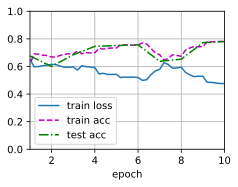

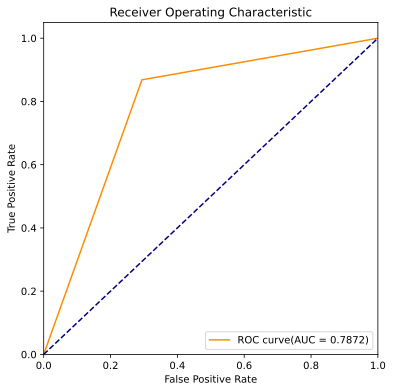

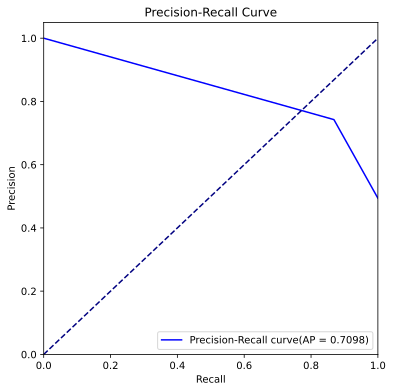

预测完成！


In [18]:
batch_size = 64
train_iter, test_iter, vocab = load_data_revi(batch_size)
lr, num_epochs = 0.001, 10
#BiRNN参数设置
embed_size, num_hiddens, num_layers = 100, 100, 2
device = torch.device('cpu')
devices = [device]  
input_csv = './feature_processing/out/test_label_data/test.label.en.csv'
output_csv = './en_predictions_birnn.csv'
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape
#训练模型
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights);
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False
#训练双向循环神经网络进行情感分析
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
print("开始训练模型...")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
print("模型训练完成！")
model_path = "trained_birnn_model.pth"
save_model(net, model_path)
#加载测试模型
print("加载模型进行测试...")
net_loaded = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
load_model(model_path, net_loaded)
batch_predict_csv(input_csv, output_csv, net_loaded, vocab)
evaluate_predictions(input_csv, output_csv)
print("预测完成！")

TextCNN参数设置

loss 0.079, train acc 0.973, test acc 0.837
335.5 examples/sec on [device(type='cpu')]
模型训练完成！
模型已保存到 trained_cnn_model.pth
加载模型进行测试...
模型已从 trained_cnn_model.pth 加载
预测结果已保存到 ./en_predictions_cnn.csv
Total samples: 3247
Accuracy: 0.8528
Precision: 0.8799
Recall:    0.8130
F1-Score:  0.8451
F2-Score:  0.8255


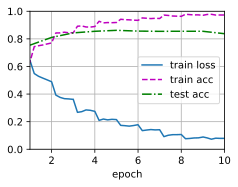

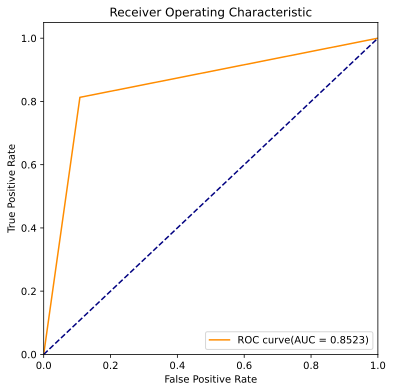

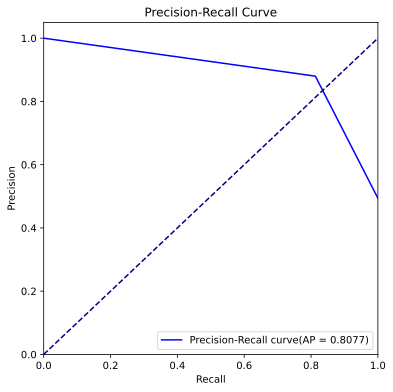

预测完成！


In [10]:
train_iter, test_iter, vocab = load_data_revi(64)
lr, num_epochs = 0.001, 10
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
device = torch.device('cpu')
devices = [device]  
input_csv = './feature_processing/out/test_label_data/test.label.en.csv'
output_csv = './en_predictions_cnn.csv'
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
net.apply(init_weights)
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
print("开始训练模型...")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
print("模型训练完成！")
model_path = "trained_cnn_model.pth"
save_model(net, model_path)
print("加载模型进行测试...")
net_loaded = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
load_model(model_path, net_loaded)
batch_predict_csv(input_csv, output_csv, net_loaded, vocab)
evaluate_predictions(input_csv, output_csv)
print("预测完成！")
